In [1]:
import numpy as np
from helpers import get_dff_fat
from constants_v1 import *

# Data frames
import pandas as pd
from helpers_pd import *
pd.options.mode.chained_assignment = None  # default='warn'

# Plotting
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.set(style="darkgrid")
import matplotlib.pyplot as plt
# plt.style.use('seaborn-white')

In [2]:
# %matplotlib nbagg

## Selecting data frames to plot

### Steps

We want to selct only 4 time series of extremes, one max and one min for each model version at a given constraint.  

- Select constraint conditions
- Get min/max DT50 value (i.e. to select the correct time series to plot).
- Get the 4 associated time series, assigne column name, e.g. "DegVar_DT50min", etc.
- Repeat for Degradation, Persistence, Leaching (as percent of degradation)
- Get any time series for total applied, make it cumulative
- Merge all TSS, compute each column as percentage


In [3]:
df = get_dff_fat(new=False, copy=True)

In [4]:
df['k_d'] = df.loc[:, 'k_oc'] * df.loc[:,'f_oc']
# Combined outlet and transects KGE Concentrations and d13C
df['KGE-SM'] = (df.loc[:, 'KGE-CONC_out'] + df.loc[:, 'KGE-CONC-tra'])/2.0  
df['KGE-d13C'] = (df.loc[:, 'KGE-d13C_out'] + df.loc[:, 'KGE-d13C-tra'])/2.0
df['Constraint'] = df.apply(WithIsoKGE, args=(0.6,), axis=1)

In [5]:
print("Maximum Conc.")
print(df['KGE-CONC-tra'].max(), df['KGE-CONC_out'].max(), df['KGE-SM'].max()) 
print("Maximum d13C")
print(df['KGE-d13C-tra'].max(), df['KGE-d13C_out'].max(), df['KGE-d13C'].max()) 

Maximum Conc.
(0.712486405538371, 0.34824560772798485, 0.4892993470470307)
Maximum d13C
(0.9031088875320538, 0.70432567774303, 0.7895610427604134)


In [6]:
dfs = df[['Model',
          'dt_50_ref',
#           'k_d',
          'epsilon_iso',
          'KGE-CONC-tra',
          'KGE-d13C-tra',
          'KGE-SM', 'KGE-d13C', 'Constraint'
          ]]

In [7]:
# Filter
ff = dfs.loc[(dfs['KGE-SM'] > 0.21)] # Try 25 with more data points
ff_c = ff.loc[(ff['KGE-d13C'] > 0.6)]
print(len(dfs), len(ff), len(ff_c))
ff.tail()

(4856, 143, 9)


,Model,dt_50_ref,epsilon_iso,KGE-CONC-tra,KGE-d13C-tra,KGE-SM,KGE-d13C,Constraint
LHS_s2var5/63/,var,27.735685,2.511350,0.259951,0.899789,0.276957,0.660586,WC
LHS_sc1var1/319/,var,30.647681,1.693283,0.309571,0.698886,0.244648,-1.176122,NC
LHS_sc1var1/64/,var,35.562792,1.183197,0.558498,0.276037,0.425198,0.222959,NC
LHS_sc1var3/83/,var,17.101488,3.954226,0.470623,0.146470,0.325851,-1.289182,NC
LHS_sc1var3/96/,var,29.637323,4.566381,0.189803,0.173100,0.237736,0.227875,NC


## Variable TSS

In [8]:
# DF1
ff_var = ff[ff['Constraint'] == 'NC']
var_max = ff_var['dt_50_ref'].max()
var_min = ff_var['dt_50_ref'].min()
print(var_min, var_max)

# DF2, Constrained model
ff_var_c = ff_c[ff_c['Constraint'] == 'WC']
var_maxc = ff_var_c['dt_50_ref'].max()
var_minc = ff_var_c['dt_50_ref'].min()

print(var_minc, var_maxc)

(10.06694087653415, 39.663271172617975)
(18.183996780553546, 32.468032952814106)


In [9]:
# Get paths and their min, max values
# var_paths = []
# var_pvals = []

# for df in dflist:
#     val = df['dt_50_ref'][(df['Model'] == 'var')].min()
#     mIndex = df.index[(ff['Model'] == 'var') & (ff['dt_50_ref'] == var_min)].tolist()[0]
#     var_paths.append(index)

var_paths = [
    ff.index[(ff['Constraint'] == 'NC') & (ff['dt_50_ref'] == var_min)].tolist()[0],
    ff.index[(ff['Constraint'] == 'NC') & (ff['dt_50_ref'] == var_max)].tolist()[0],
    ff_c.index[(ff_c['Constraint'] == 'WC') & (ff_c['dt_50_ref'] == var_minc)].tolist()[0],
    ff_c.index[(ff_c['Constraint'] == 'WC') & (ff_c['dt_50_ref'] == var_maxc)].tolist()[0]
]

var_pvals = [
    ff['dt_50_ref'][(ff['Constraint'] == 'NC')].min(),
    ff['dt_50_ref'][(ff['Constraint'] == 'NC')].max(),
    ff_c['dt_50_ref'][(ff_c['Constraint'] == 'WC')].min(),
    ff_c['dt_50_ref'][(ff_c['Constraint'] == 'WC')].max()
]

df_types = [
    'vNC', # no constraint
    'vNC',
    'vWC', # with constraint
    'vWC'
]

print(var_paths[0], var_paths[1])
print(var_pvals[0], var_pvals[1])
print(var_paths[2], var_paths[3])
print(var_pvals[2], var_pvals[3])

('LHS_gu1var6/2/', 'LHS_gu1var5/2/')
(10.06694087653415, 39.663271172617975)
('LHS_p1fix4/8/', 'LHS_p1var6/179/')
(18.183996780553546, 32.468032952814106)


### Get cumulative applied mass (grams)

All data frames have this time series, and does not change (inefficiency yes)

In [10]:
path = var_paths[0]
app = pd.read_table(path + "resM_accAPP.tss", 
                   skiprows=4, delim_whitespace=True,
                                names=['Jdays', 'app'],
                                header=None)
# time = app['Jdays']
app['Capp'] = app['app'].cumsum()
# app.head()

## Persistence

In [26]:
filename = "resM_light_real_z0.tss"
vname = 'Persist'
print(vname)

sets = []
for i in range(len(var_paths)):
    # Define variable name
    series_name = vname + '.' + str(int(var_pvals[i])) + df_types[i]
    # Get sim TSS
    sim = pd.read_table(var_paths[i] + filename, 
                   skiprows=4, delim_whitespace=True,
                                names=['Jdays', series_name],
                                header=None
                  )
    # Cumalte mass degraded
    sim['Cper'] = sim[series_name]
    
    # Calculate percentage, retain.
    sim = pd.merge(app, sim, how='inner', on='Jdays')
    sim[series_name] = 100*(sim['Cper']/sim['Capp'])
    sim = sim[['Jdays', series_name]]
    
    sim = pd.melt(sim, id_vars=['Jdays'],
             value_vars=[series_name])
    
    if i < 2:
        sim['Type'] = sim.apply (lambda row: ModelType(row, 'Un-constrained'),axis=1) 
    else: 
        sim['Type'] = sim.apply (lambda row: ModelType(row, 'Constrained'),axis=1) 
        
    sim = sim.loc[5:, ]
    
    sets.append(sim)
    
    
sdf = pd.concat(sets)    
# sdf = reduce(lambda left, right: pd.merge(left,right,on='Jdays'), sets)

sdf.head()


Persist


,Jdays,variable,value,Type
5,171,Persist.10vNC,95.059503,Un-constrained
6,172,Persist.10vNC,88.244354,Un-constrained
7,173,Persist.10vNC,82.105020,Un-constrained
8,174,Persist.10vNC,76.641689,Un-constrained
9,175,Persist.10vNC,71.589170,Un-constrained


In [21]:
# sns.lineplot(x="Jdays", y="value", data=sets[0], hue="Type")

In [27]:
print(sets[0]['value'].min())
sets[0].tail()

2.9936343415754156


,Jdays,variable,value,Type
116,282,Persist.10vNC,3.492489,Un-constrained
117,283,Persist.10vNC,3.342506,Un-constrained
118,284,Persist.10vNC,3.209327,Un-constrained
119,285,Persist.10vNC,3.105645,Un-constrained
120,286,Persist.10vNC,2.993634,Un-constrained


In [25]:
# sns.lineplot(x="Jdays", y="value", data=sets[1], hue="Type")

In [28]:
print(sets[1]['value'].min())
sets[1].tail()

5.41897076144117


,Jdays,variable,value,Type
116,282,Persist.39vNC,6.055201,Un-constrained
117,283,Persist.39vNC,5.975038,Un-constrained
118,284,Persist.39vNC,5.902133,Un-constrained
119,285,Persist.39vNC,5.497770,Un-constrained
120,286,Persist.39vNC,5.418971,Un-constrained


In [29]:
sets[2].tail()

,Jdays,variable,value,Type
116,282,Persist.18vWC,6.107000,Constrained
117,283,Persist.18vWC,5.908574,Constrained
118,284,Persist.18vWC,5.717512,Constrained
119,285,Persist.18vWC,5.506036,Constrained
120,286,Persist.18vWC,5.329471,Constrained


In [30]:
sets[3].tail()

,Jdays,variable,value,Type
116,282,Persist.32vWC,12.666007,Constrained
117,283,Persist.32vWC,12.433153,Constrained
118,284,Persist.32vWC,12.223503,Constrained
119,285,Persist.32vWC,11.913633,Constrained
120,286,Persist.32vWC,11.676731,Constrained


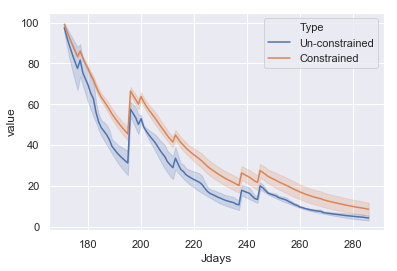

In [15]:
sns.lineplot(x="Jdays", y="value", data=sdf, hue="Type")

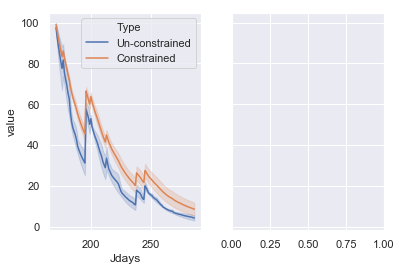

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True)
sns.lineplot(x="Jdays", y="value", data=sdf, hue="Type", ax=ax1)
plt.show()